# Imports:

In [3]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, models, preprocessing, losses
import matplotlib.pyplot as plt
from os import listdir, mkdir, path
import numpy as np
from PIL import Image

# Load Coin Dataset:

## Settings:

In [7]:
# Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# dataset_dir = '/content/drive/MyDrive/images_grade/'
# model_dir = '/content/drive/MyDrive/coin_grader_model/'

# Local
dataset_dir = 'images_grade/'
model_dir = 'coin_grader_model/'

batch_size = 64
img_size = 128

## Image augmentation:

In [9]:
class RandomBrightness(layers.Layer):
  def __init__(self, delta, **kwargs):
    super(RandomBrightness, self).__init__(**kwargs)
    self.delta = delta

  def __call__(self, images, **kwargs):
    def random_brightness(image):
      return tf.image.random_brightness(image, self.delta)
    images = tf.map_fn(random_brightness, images)
    return tf.clip_by_value(images, 0, 1)

class RandomContrast(layers.Layer):
  def __init__(self, range, **kwargs):
    super(RandomContrast, self).__init__(**kwargs)
    self.range = range

  def __call__(self, images, **kwargs):
    def random_contrast(image):
      return tf.image.random_contrast(image, self.range[0], self.range[1])
    images = tf.map_fn(random_contrast, images)
    return tf.clip_by_value(images, 0, 1)

augment = models.Sequential([
  layers.RandomZoom((0, 0.2), fill_mode="constant", fill_value=1),
  layers.RandomRotation(0.05, fill_mode="constant", fill_value=1),
  layers.RandomTranslation(0.1, 0.1, fill_mode="constant", fill_value=1),
  RandomBrightness(0.2),
  RandomContrast((0.8, 1))
])

## Load dataset:

In [10]:
labels = listdir(dataset_dir)
labels.sort()

if '.DS_Store' in labels:
  labels.remove('.DS_Store')

dataset = preprocessing.image_dataset_from_directory(
  dataset_dir,
  labels="inferred",
  label_mode="int",
  class_names=None,
  color_mode="rgb",
  batch_size=batch_size,
  image_size=(img_size, img_size),
  shuffle=True,
)
dataset = dataset.map(lambda image, label: (image / 255.0, label))
datasets = [dataset.map(lambda image, label: (augment(image), label)) for _ in range(9)]
for ds in datasets:
  dataset = dataset.concatenate(ds)

Found 4070 files belonging to 10 classes.


# Display Coin Images:

2021-10-22 15:38:23.684193: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


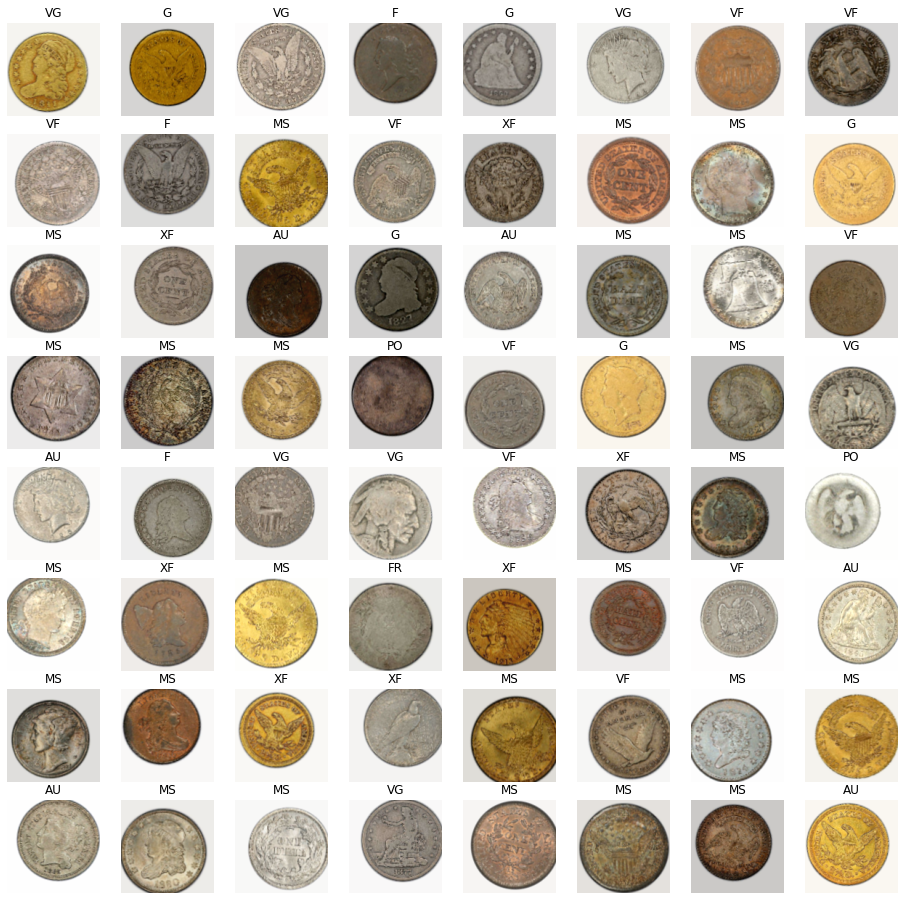

In [11]:
fig = plt.figure(figsize=(16, 16))
X_batch, y_batch = next(dataset.as_numpy_iterator())
X_batch = np.clip(augment(X_batch), 0, 1)
for i in range(batch_size):
  fig.add_subplot(8, 8, i + 1)
  plt.imshow(X_batch[i])
  plt.axis('off')
  plt.title(labels[y_batch[i]])

# Create CNN:

In [12]:
model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.25),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.25),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Dense(119),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)       

# Train Model:

In [ ]:
model.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.fit(dataset, epochs=12)

# Save/Load Model:

## Save model:

In [ ]:
model.save(model_dir)

## Save model using TFLite:

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(model_dir)
tflite_model = converter.convert()
with open('coin_classifier.tflite', 'wb') as f:
  f.write(tflite_model)

## Load model:

In [ ]:
model = models.load_model(model_dir)

## Load model using TFLite:

In [ ]:
# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="coin_classifier.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test Images:

In [61]:
correct = {}
total = {}
for i in range(len(labels)):
  correct[i] = 0
  total[i] = 0
for X, y in dataset:
  preds = [np.argmax(pred) for pred in model.predict(X)]
  for i, pred in enumerate(preds):
    true = y[i].numpy()
    if pred == true:
      correct[true] += 1
    total[true] += 1
for label, count in correct.items():
  acc = count / total[label]
  print('%s: %.2f' % (labels[label], acc))

AG: 0.95
AU: 0.94
F: 0.97
FR: 0.92
G: 1.00
MS: 1.00
PO: 1.00
VF: 0.98
VG: 0.99
XF: 0.99


1: MS
2: F
3: XF
4: AU
5: VF
Text:  



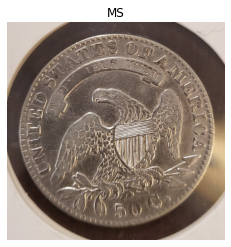

In [73]:
img = Image.open('test12.jpg')
img = img.resize(size=(500, 500))
img_data = np.divide(preprocessing.image.img_to_array(img), 255.0)

# X, y = next(dataset.as_numpy_iterator())
# img_data = X[0]
# print('True: %s' % labels[y[0]])

img_dataset = tf.data.Dataset.from_tensors([img_data])
prediction = model.predict(img_dataset)[0]
plt.title(labels[np.argmax(prediction)])
plt.axis('off')
plt.imshow(img_data)
ranked = np.argsort(prediction)
print('1: %s' % labels[ranked[-1]])
print('2: %s' % labels[ranked[-2]])
print('3: %s' % labels[ranked[-3]])
print('4: %s' % labels[ranked[-4]])
print('5: %s' % labels[ranked[-5]])

print('Text: %s' % pytesseract.image_to_string(img))